# Step 1: Imports

In [ ]:
import os
import shutil
import plotly.express as px
import pandas as pd
import tensorflow as tf
import nibabel as nib
import cv2
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
import numpy as np
from sklearn.model_selection import train_test_split


from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from glob import glob
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [ ]:
from imageio import imwrite

In [ ]:
!pip install segmentation-models-3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.4 MB/s eta 0:00:00


# Step 2: Load dataset

## Defining paths of dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
scaler = MinMaxScaler()

# rename 355 to match the folder structure

TRAIN_DATASET_PATH = '/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

os.listdir(TRAIN_DATASET_PATH)
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_200/BraTS20_Training_200_flair.nii').get_fdata()
print(test_image_flair.max())
# Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

367.0


In [ ]:
test_image_flair.shape

(240, 240, 155)

[0 1 2 4]
[0 1 2 3]


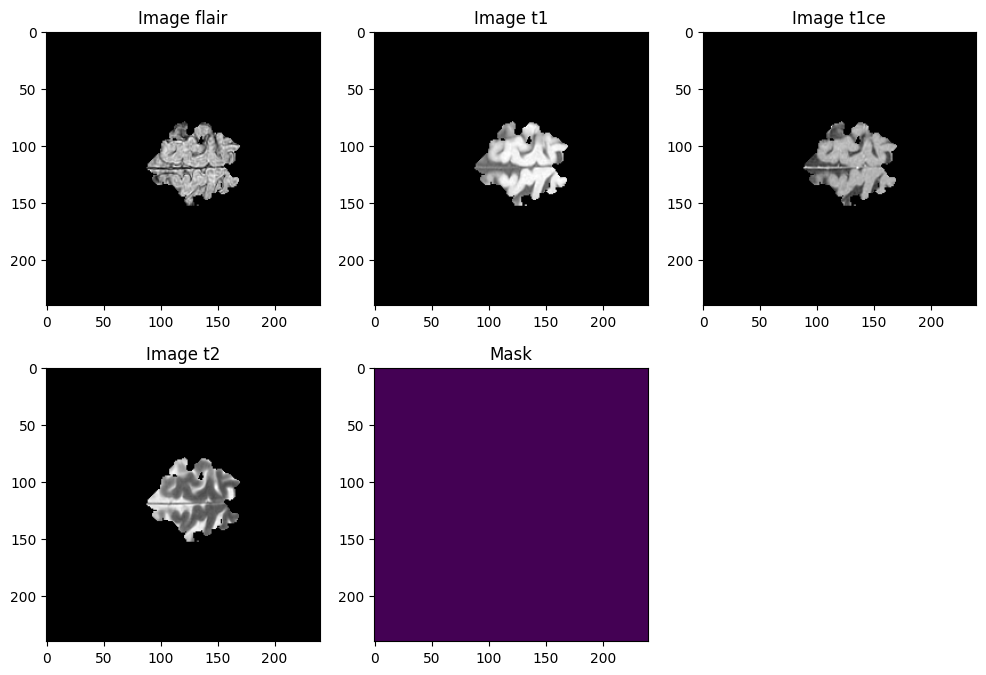

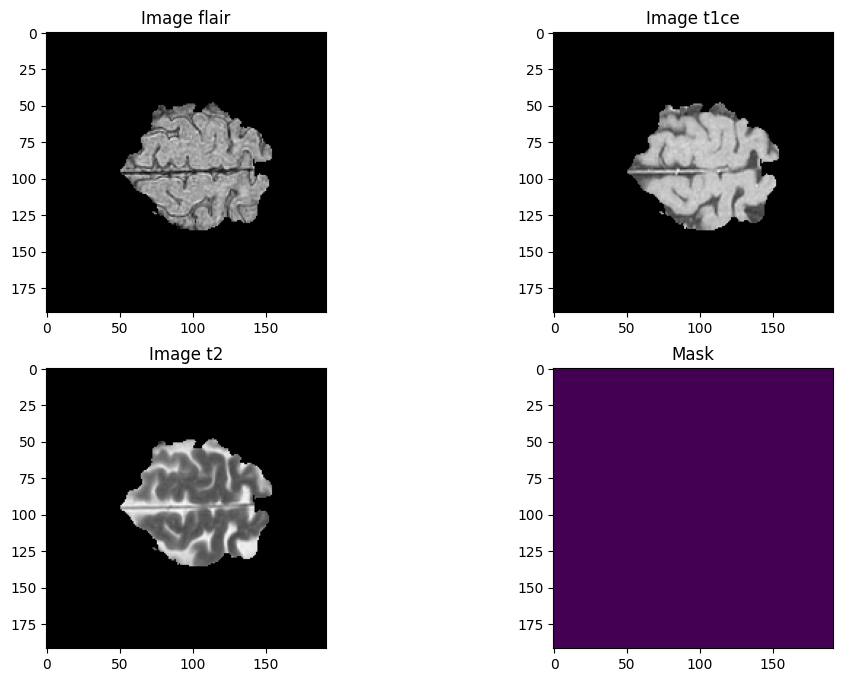

In [ ]:
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_200/BraTS20_Training_200_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_200/BraTS20_Training_200_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_200/BraTS20_Training_200_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_200/BraTS20_Training_200_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()



##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141] # (240-192 = 48/2 = 24 => 24:216)
#new 192 x 192 x 128

combined_x=combined_x[24:216, 24:216, 13:141] #Crop to 128x128x128x4  # prev for 128 x 128 x 128 ~ 56:184, 56:184, 13:141

#Do the same for mask
test_mask = test_mask[24:216, 24:216, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
# # imwrite('/content/drive/MyDrive/BraTS2020_TrainingData/combined255.tif', combined_x)
# # np.save('/content/drive/MyDrive/BraTS2020_TrainingData/combined200.npy', combined_x)
# #Verify image is being read properly
# #my_img=imread('BraTS2020_TrainingData/combined255.tif')
# # my_img=np.load('/content/drive/MyDrive/BraTS2020_TrainingData/combined200.npy')

# # test_mask = to_categorical(test_mask, num_classes=4)
# ####################################################################
# #####################################
# #End of understanding the dataset. Now get it organized.
# #####################################

# #Now let us apply the same as above to all the images...
# #Merge channels, crop, patchify, save
# #GET DATA READY =  GENERATORS OR OTHERWISE

# #Keras datagenerator does ntot support 3d

# # # # images lists harley
# #t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))[:184]
# t2_list = sorted(glob('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))[:184]
# t1ce_list = sorted(glob('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))[:184]
# flair_list = sorted(glob('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))[:184]
# mask_list = sorted(glob('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))[:184]

# #Each volume generates 18 64x64x64x4 sub-volumes.
# #Total 369 volumes = 6642 sub volumes

# for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
#     print("Now preparing image and masks number: ", img)

#     temp_image_t2=nib.load(t2_list[img]).get_fdata()
#     temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

#     temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
#     temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

#     temp_image_flair=nib.load(flair_list[img]).get_fdata()
#     temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

#     temp_mask=nib.load(mask_list[img]).get_fdata()
#     temp_mask=temp_mask.astype(np.uint8)
#     temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
#     #print(np.unique(temp_mask))


#     temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

#     #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
#     #cropping x, y, and z
#     temp_combined_images=temp_combined_images[48:192, 48:192, 10:154]
#     temp_mask = temp_mask[48:192, 48:192, 10:154]

#     val, counts = np.unique(temp_mask, return_counts=True)
#     if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
#         print("Save Me")
#         temp_mask= to_categorical(temp_mask, num_classes=4)
#         np.save('/content/drive/MyDrive/BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
#         np.save('/content/drive/MyDrive/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)

#     else:
#         print("I am useless")

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
################################################################
#Repeat the same from above for validation data folder OR
#Split training data into train and validation

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators.
pip install split-folders
"""

input_folder = '/content/drive/MyDrive/BraTS2020_TrainingData/input_data_3channels/'
output_folder = '/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input=input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values


Copying files: 0 files [00:00, ? files/s]
Copying files: 2 files [00:00,  4.27 files/s]
Copying files: 3 files [00:01,  1.65 files/s]
Copying files: 4 files [00:03,  1.11 files/s]
Copying files: 5 files [00:04,  1.04s/ files]
Copying files: 6 files [00:05,  1.13s/ files]
Copying files: 7 files [00:07,  1.43s/ files]
Copying files: 8 files [00:08,  1.37s/ files]
Copying files: 9 files [00:11,  1.72s/ files]
Copying files: 10 files [00:12,  1.57s/ files]
Copying files: 11 files [00:14,  1.68s/ files]
Copying files: 12 files [00:16,  1.85s/ files]
Copying files: 13 files [00:17,  1.64s/ files]
Copying files: 14 files [00:19,  1.66s/ files]
Copying files: 15 files [00:21,  1.84s/ files]
Copying files: 16 files [00:23,  1.88s/ files]
Copying files: 17 files [00:26,  2.16s/ files]
Copying files: 18 files [00:28,  1.95s/ files]
Copying files: 19 files [00:29,  1.75s/ files]
Copying files: 20 files [00:30,  1.60s/ files]
Copying files: 21 files [00:32,  1.53s/ files]
Copying files: 22 files [

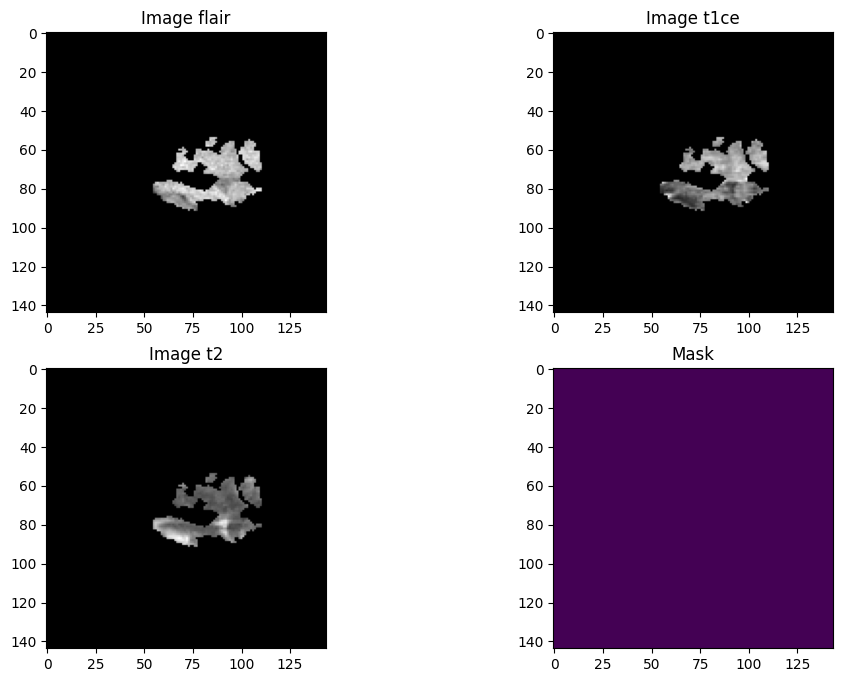

(144, 144, 144)

In [ ]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
          image = np.load(img_dir+image_name, allow_pickle=True)

          images.append(image)
    images = np.array(images)

    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

############################################

#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/train/images/"
train_mask_dir = "/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()
test_mask.shape

# **Model**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(144, 144, 144, 3, 4)
print(model.input_shape)
print(model.output_shape)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 144, 1  0           []                               
                                44, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 144, 144, 14  1312        ['input_1[0][0]']                
                                4, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 144, 144, 14  0           ['conv3d[0][0]']                 
                                4, 16)                                                        

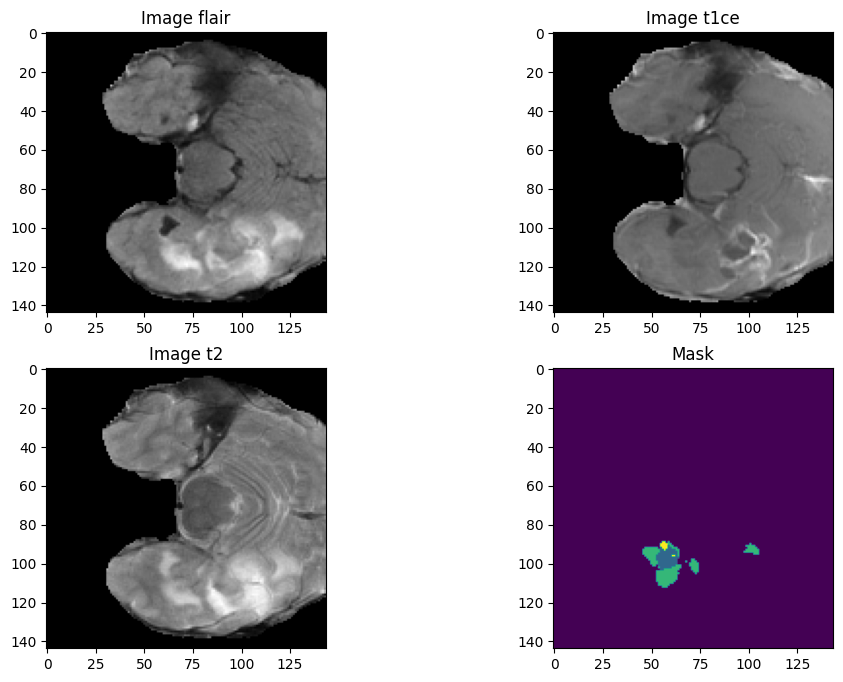

In [ ]:
import os
import numpy as np
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random



####################################################
train_img_dir = "/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/train/images/"
train_mask_dir = "/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
#############################################################
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    df = df.append(conts_dict, ignore_index=True)

0
1


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


2


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


3


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


4


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


5


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


6


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


7


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


8


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


9


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


10


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


11


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


12


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


13


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


14


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


15


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


16


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


17


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


18


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


19


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


20


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


21


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


22


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


23


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


24


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


25


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


26


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


27


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


28


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


29


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


30


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


31


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


32


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


33


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


34


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


35


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


36


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


37


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


38


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


39


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


40


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


41


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


42


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


43


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


44


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


45


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


46


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


47
48


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


49


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


50


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


51


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


52


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


53


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


54


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


55


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


56


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


57


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


58


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


59


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


60


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


61


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


62


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


63


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


64


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


65


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


66


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


67


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


68


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


69


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


70


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


71


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


72


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


73


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


74


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


75


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


76


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


77


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


78


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


79


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


80


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


81


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


82


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


83


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


84


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


85


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


86


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


87


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


88


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


89


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


90


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


91


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


92


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


93


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


94


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


95


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


96


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


97


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


98


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


99


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


100


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


101


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


102


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


103


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


104


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


105


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


106


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


107


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


108


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


109


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


110


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


111


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


112


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


113


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


114


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


115


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


116


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


117


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


118


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


119


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


120


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


121


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


122


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


123


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


124


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


125


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


126


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


127


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


128


<ipython-input-37-e03ea3a7fb24>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


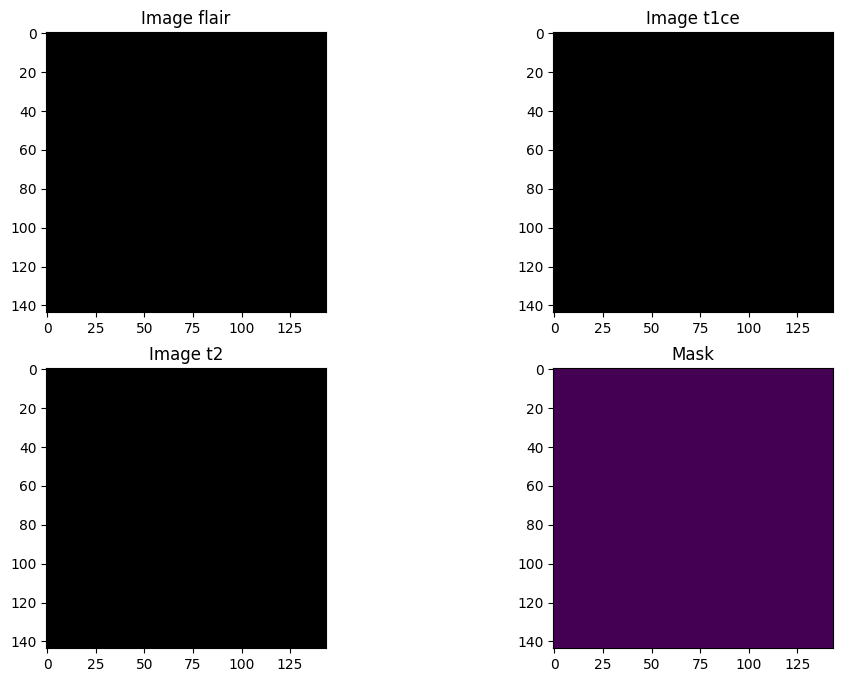

Segmentation Models: using `tf.keras` framework.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 144, 144, 1  0           []                               
                                44, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 144, 144, 14  1312        ['input_2[0][0]']                
                                4, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 144, 144, 14  0           ['conv3d_19[0][0]']              
                                4, 16)     

In [ ]:
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss

##############################################################
#Define the image generators for training and validation

train_img_dir = "/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/train/images/"
train_mask_dir = "/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/train/masks/"

val_img_dir = "/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/val/images/"
val_mask_dir = "/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)
#######################################################################
#Fit the model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


model = simple_unet_model(IMG_HEIGHT=144,
                          IMG_WIDTH=144,
                          IMG_DEPTH=144,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

In [ ]:
# import os
# checkpoint_path = "training_2\cp.ckpt"

# checkpoint_dir = os.path.dirname(checkpoint_path)

## Create checkpoint  callback
#callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc',save_best_only=True,save_weights_only=True,verbose=1)

path_checkpoint = "/content/drive/MyDrive/BraTS2020_TrainingData/training_2/cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)

model.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_144.hdf5')
# model.load_weights(path_checkpoint)
# callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
#                                                  save_weights_only=True,
#                                                  verbose=1)
history=model.fit(train_img_datagen,
          steps_per_epoch=23,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/10
23/23 [==============================] - 116s 5s/step - loss: 0.9496 - accuracy: 0.9397 - iou_score: 0.2635 - val_loss: 0.9270 - val_accuracy: 0.8076 - val_iou_score: 0.3190
Epoch 2/10
23/23 [==============================] - 118s 5s/step - loss: 0.9438 - accuracy: 0.9431 - iou_score: 0.2440 - val_loss: 0.9440 - val_accuracy: 0.7668 - val_iou_score: 0.2674
Epoch 3/10
23/23 [==============================] - 109s 5s/step - loss: 0.9401 - accuracy: 0.9415 - iou_score: 0.2417 - val_loss: 0.9246 - val_accuracy: 0.9645 - val_iou_score: 0.3597
Epoch 4/10
23/23 [==============================] - 108s 5s/step - loss: 0.9375 - accuracy: 0.9622 - iou_score: 0.2534 - val_loss: 0.9338 - val_accuracy: 0.9076 - val_iou_score: 0.3395
Epoch 5/10
23/23 [==============================] - 120s 5s/step - loss: 0.9387 - accuracy: 0.9567 - iou_score: 0.2409 - val_loss: 0.9283 - val_accuracy: 0.9613 - val_iou_score: 0.3580
Epoch 6/10
23/23 [==============================] - 106s 5s/step - loss: 0.

In [ ]:
model.save_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_144_2.hdf5')

In [ ]:
# os.listdir('/content//drive/MyDrive/BraTS2020_TrainingData/training_1/')

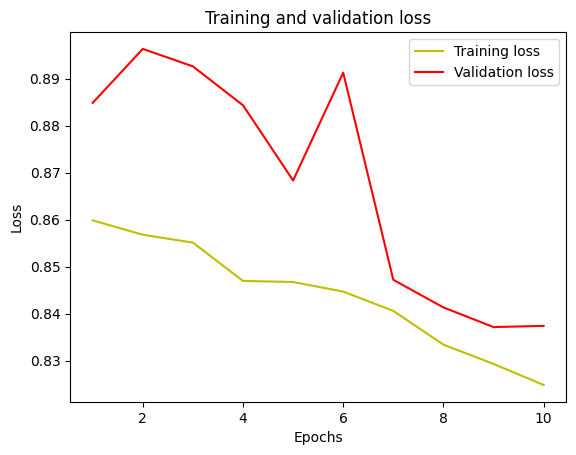

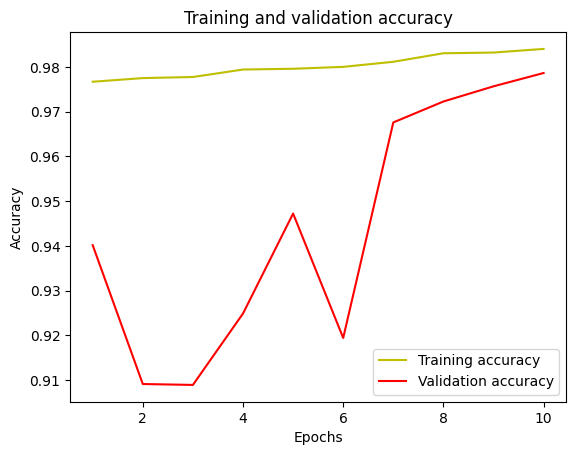

1/1 [==============================] - 0s 365ms/step
Mean IoU = 0.545064


In [ ]:
# model.save('/content/drive/MyDrive/brats_3d_144.hdf5')
##################################################################


#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#################################################
from keras.models import load_model

#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and
#continue training we need to provide these as custom_objects.
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      # custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      # custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      # 'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
# history2=my_model.fit(train_img_datagen,
          # steps_per_epoch=steps_per_epoch,
          # epochs=1,
          # verbose=1,
          # validation_data=val_img_datagen,
          # validation_steps=val_steps_per_epoch,
          # )
#################################################

#For predictions you do not need to compile the model, so ...
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      # compile=False)


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 80ms/step


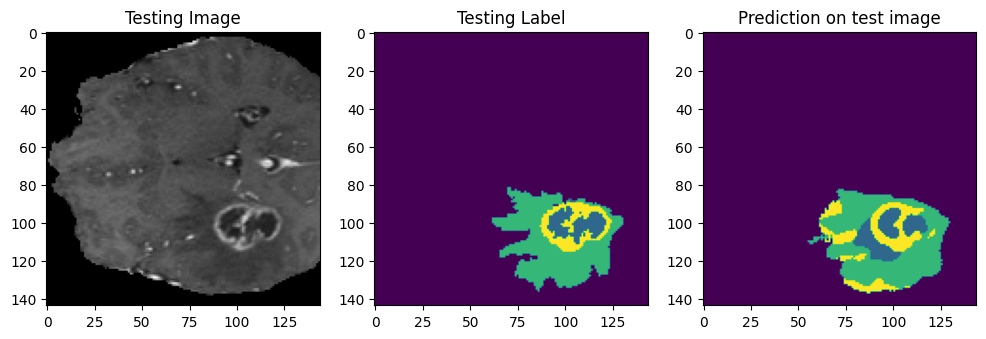

In [ ]:

#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 82
model.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_144.hdf5')

test_img = np.load("/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

1/1 [==============================] - 0s 85ms/step


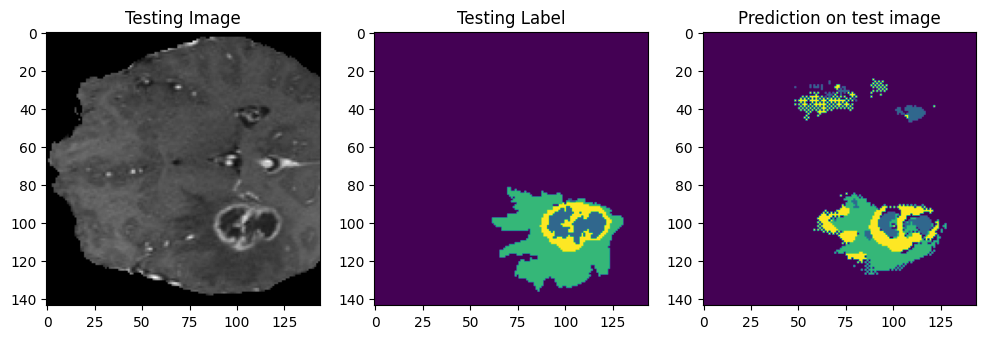

In [ ]:

#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 82
model.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_144_2.hdf5')

test_img = np.load("/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))
# print(test_prediction_argmax)


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()